# 6.6: Sourcing & Analyzing Time Series Data

## Table of Contents

[01. Importing libraries](#01.-Importing-libraries)

[02. Imporing Data](#02.-Imporing-Data)

[03. Data Preparation](#03.-Data-Preparation)

[04. Time-series analysis: decomposition](#04.-Time-series-analysis:-decomposition)

[05. Testing for stationarity](#05.-Testing-for-stationarity)

[06. Differencing the Series](#06.-Differencing-the-Series)

## 01. Importing libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

## 02. Imporing Data

In [2]:
# Import Divvy_trip dataset
df = pd.read_pickle( r'E:\Careerfoundry course\My Project\Generated Data\Divvy_cleaned.pkl')

In [3]:
# This option ensures the graphs you create are displayed in your notebook without the need to "call" them specifically.

%matplotlib inline

In [4]:
df.head()

,trip_id,start_time,end_time,bike_id,trip_duration,from_station_id,from_station_name,to_station_id,to_station_name,user_type,...,to_latitude,to_longitude,to_location,year,month_start,month_end,day,hour_start,hour_end,age
0,8546790,2015-12-31 17:35:00,2015-12-31 17:44:00,979,521,117,Wilton Ave & Belmont Ave,229,Southport Ave & Roscoe St,Subscriber,...,41.943739,-87.664020,POINT (-87.66402 41.943739),2015,12,12,Thursday,17,17,24
1,8546793,2015-12-31 17:37:00,2015-12-31 17:41:00,1932,256,301,Clark St & Schiller St,138,Clybourn Ave & Division St,Subscriber,...,41.904613,-87.640552,POINT (-87.640552 41.904613),2015,12,12,Thursday,17,17,23
2,8546795,2015-12-31 17:37:00,2015-12-31 17:40:00,1693,134,465,Marine Dr & Ainslie St,251,Clarendon Ave & Leland Ave,Subscriber,...,41.967968,-87.650001,POINT (-87.650001 41.967968),2015,12,12,Thursday,17,17,28
3,8546797,2015-12-31 17:38:00,2015-12-31 17:55:00,3370,995,333,Ashland Ave & Blackhawk St,198,Green St (Halsted St) & Madison St,Subscriber,...,41.881892,-87.648789,POINT (-87.648789 41.881892),2015,12,12,Thursday,17,17,40
4,8546798,2015-12-31 17:38:00,2015-12-31 17:41:00,2563,177,48,Larrabee St & Kingsbury St,111,Sedgwick St & Huron St,Subscriber,...,41.894666,-87.638437,POINT (-87.638437 41.894666),2015,12,12,Thursday,17,17,25


## 03. Data Preparation

For a time series analysis with the Divvy dataset, we should focus on a subset of data with temporal 
continuity and relevance to analysis goals. To create a subset of the historical domain, there are some 
steps to be followed:

In [5]:
#  Ensures the start_time and end_time columns are in datetime format.
df.dtypes

trip_id                      object
start_time           datetime64[ns]
end_time             datetime64[ns]
bike_id                      object
trip_duration                 int64
from_station_id              object
from_station_name            object
to_station_id                object
to_station_name              object
user_type                    object
gender                       object
birth_year                    int32
from_latitude               float64
from_longitude              float64
from_location                object
to_latitude                 float64
to_longitude                float64
to_location                  object
year                          int32
month_start                   int32
month_end                     int32
day                          object
hour_start                    int32
hour_end                      int32
age                           int32
dtype: object

In [6]:
# Filter data for the years 2015 to 2019
df_filtered = df[(df['start_time'].dt.year >= 2015) & (df['start_time'].dt.year <= 2019)]

In [7]:
df_filtered.head(2)

,trip_id,start_time,end_time,bike_id,trip_duration,from_station_id,from_station_name,to_station_id,to_station_name,user_type,...,to_latitude,to_longitude,to_location,year,month_start,month_end,day,hour_start,hour_end,age
0,8546790,2015-12-31 17:35:00,2015-12-31 17:44:00,979,521,117,Wilton Ave & Belmont Ave,229,Southport Ave & Roscoe St,Subscriber,...,41.943739,-87.664020,POINT (-87.66402 41.943739),2015,12,12,Thursday,17,17,24
1,8546793,2015-12-31 17:37:00,2015-12-31 17:41:00,1932,256,301,Clark St & Schiller St,138,Clybourn Ave & Division St,Subscriber,...,41.904613,-87.640552,POINT (-87.640552 41.904613),2015,12,12,Thursday,17,17,23


In [8]:
# Choose time-related columns that are necessary for the analysis. 
X = df_filtered[['start_time', 'end_time','trip_id', 'trip_duration', 'hour_start', 'day', 'month_start']]

In [9]:
X.head(2)

,start_time,end_time,trip_id,trip_duration,hour_start,day,month_start
0,2015-12-31 17:35:00,2015-12-31 17:44:00,8546790,521,17,Thursday,12
1,2015-12-31 17:37:00,2015-12-31 17:41:00,8546793,256,17,Thursday,12


In [10]:
X['trip_duration'].describe()

count    1.802124e+07
mean     1.137328e+03
std      1.633414e+04
min      6.000000e+01
25%      4.060000e+02
50%      6.980000e+02
75%      1.201000e+03
max      1.163500e+07
Name: trip_duration, dtype: float64

In [11]:
# Exclude trips that might skew the time series, such as extremely long trips (outliers) or zero-duration trips.
# Remove trips that are extremely long (e.g., trips longer than 12 hours)
X = X[X['trip_duration'] <= 12 * 60 * 60]  # 12 hours = 43200 seconds

# Optional: remove trips with zero or negative duration to clean the data
df_filtered = df_filtered[df_filtered['trip_duration'] > 0]

In [12]:
X['trip_duration'].describe()

count    1.800946e+07
mean     1.012248e+03
std      1.326576e+03
min      6.000000e+01
25%      4.060000e+02
50%      6.980000e+02
75%      1.199000e+03
max      4.319900e+04
Name: trip_duration, dtype: float64

In [13]:
# aggregate trips by specific time intervals (daily)to smooth out noise and focus on trends.
X['date'] = X['start_time'].dt.date
daily_trips = X.groupby('date')['trip_id'].count().reset_index()

In [14]:
X.head(2)

,start_time,end_time,trip_id,trip_duration,hour_start,day,month_start,date
0,2015-12-31 17:35:00,2015-12-31 17:44:00,8546790,521,17,Thursday,12,2015-12-31
1,2015-12-31 17:37:00,2015-12-31 17:41:00,8546793,256,17,Thursday,12,2015-12-31


In [15]:
daily_trips 

,date,trip_id
0,2015-01-01,860
1,2015-01-02,2473
2,2015-01-03,697
3,2015-01-04,401
4,2015-01-05,1220
...,...,...
1821,2019-12-27,3968
1822,2019-12-28,2757
1823,2019-12-29,3892
1824,2019-12-30,3301


In [16]:
# Setting the Date Column as the Index
daily_trips.set_index('date', inplace=True)

In [17]:
daily_trips.head(2)

,trip_id
date,
2015-01-01,860
2015-01-02,2473


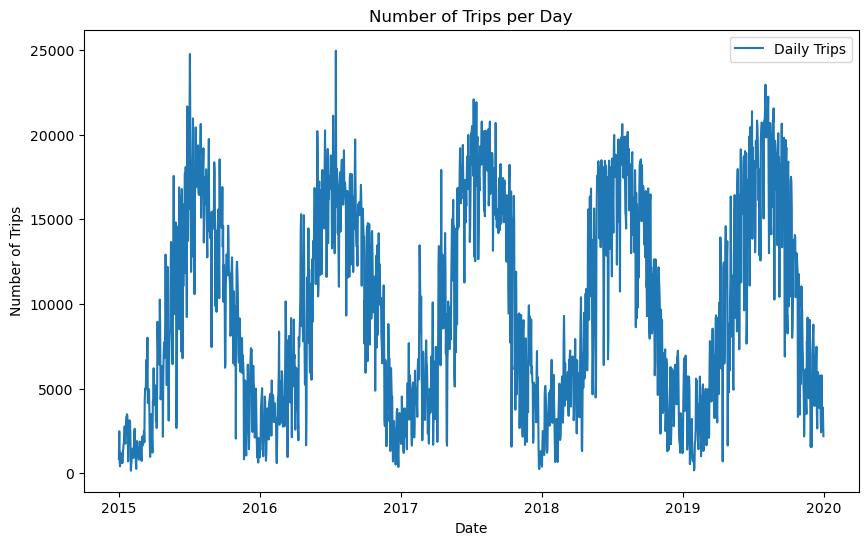

In [18]:
# Plot the number of trips over time
plt.figure(figsize=(10,6))
plt.plot(daily_trips.index, daily_trips['trip_id'], label='Daily Trips')
plt.title('Number of Trips per Day')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.legend()
plt.show()

In [19]:
# Check for missing values (you shouldn't have any)

daily_trips.isnull().sum() 

trip_id    0
dtype: int64

In [20]:
# Check for duplicates
dups = daily_trips.duplicated()
dups.sum()


74

In [21]:
# Remove duplicates
daily_trips_cleaned = daily_trips.drop_duplicates()

# Verify that duplicates are removed
print(f"Number of duplicates after removal: {daily_trips_cleaned.duplicated().sum()}")

Number of duplicates after removal: 0


## 04. Time-series analysis: decomposition

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose

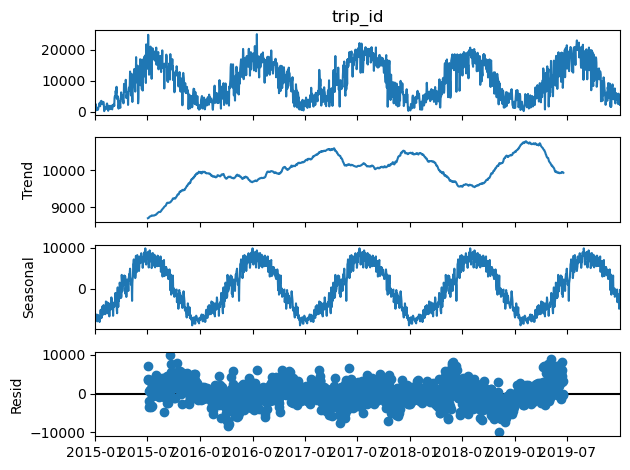

In [23]:
# Perform seasonal decomposition 
decomposition = seasonal_decompose(daily_trips_cleaned['trip_id'], model='additive', period=365)  # Assuming daily data with yearly seasonality

# Plot the decomposed components
decomposition.plot()
plt.show()

#### The decomposition reveals significant seasonal variation and an upward trend in bike-sharing usage, providing insights for optimizing bike availability and enhancing user experience.
1. Observed Data: Shows a clear cyclic pattern in bike trips, indicating seasonal fluctuations likely influenced by weather and events.
2. Trend Component: Displays a gradual increase in trips over time, suggesting growing popularity of bike-sharing, with some fluctuations.
3. Seasonal Component: Highlights strong seasonality with repeating patterns, indicating increased usage during warmer months and weekends.
4. Residual Component: Residuals fluctuate around zero, indicating the model captures systematic variation well, though some outliers may require further investigation.

## 05. Testing for stationarity

In [24]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

# Perform Dickey-Fuller test
result = adfuller(daily_trips_cleaned['trip_id'])

# Extracting test statistics and p-value
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

# Print the results
print('Dickey-Fuller Test Statistic:', adf_statistic)
print('p-value:', p_value)
print('Critical Values:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')

Dickey-Fuller Test Statistic: -2.4853288632466275
p-value: 0.11908490029295898
Critical Values:
   1%: -3.4341159453366448
   5%: -2.863203454843483
   10%: -2.5676555752134256


### Interpret the results
-The test statistic of -2.4853 is greater than the critical values for both the 1% and 5% significance levels.
-p-value: The p-value of 0.1191 is greater than 0.05, indicating that we fail to reject the null hypothesis
at the 5% significance level. This implies that the time series is likely non-stationary.

-Given these results, it suggests that you should consider differencing the series or applying other transformations (such as seasonal differencing) to stabilize the mean and variance before proceeding with further analysis or modeling.

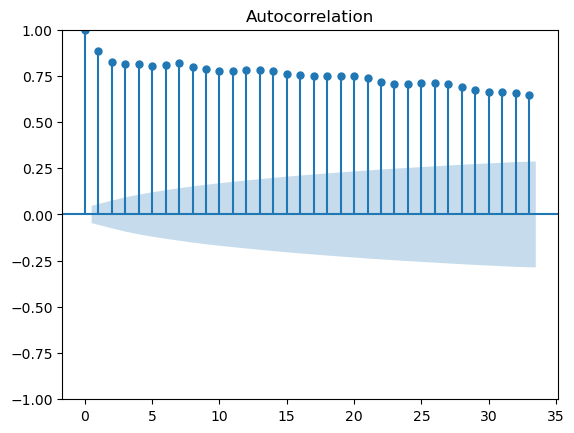

In [25]:
# Check out a plot of autocorrelations
plot_acf(daily_trips_cleaned['trip_id'])
plt.show()

## 06. Differencing the Series

In [26]:
# Apply differencing to remove trends and seasonality, making the series stationary.
# We can start with first-order differencing (subtracting the previous observation from the current observation).

data_diff = daily_trips_cleaned - daily_trips_cleaned.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [27]:
# Perform the Dickey-Fuller test again on the differenced series to check if it has become stationary.
data_diff.dropna(inplace = True)  # Here, we remove the missing values that came about as a result of the differencing. 
# we need to remove these or we won't be able to run the Dickey-Fuller test.

In [28]:
data_diff.head()

,trip_id
date,
2015-01-02,1613.0
2015-01-03,-1776.0
2015-01-04,-296.0
2015-01-05,819.0
2015-01-06,-269.0


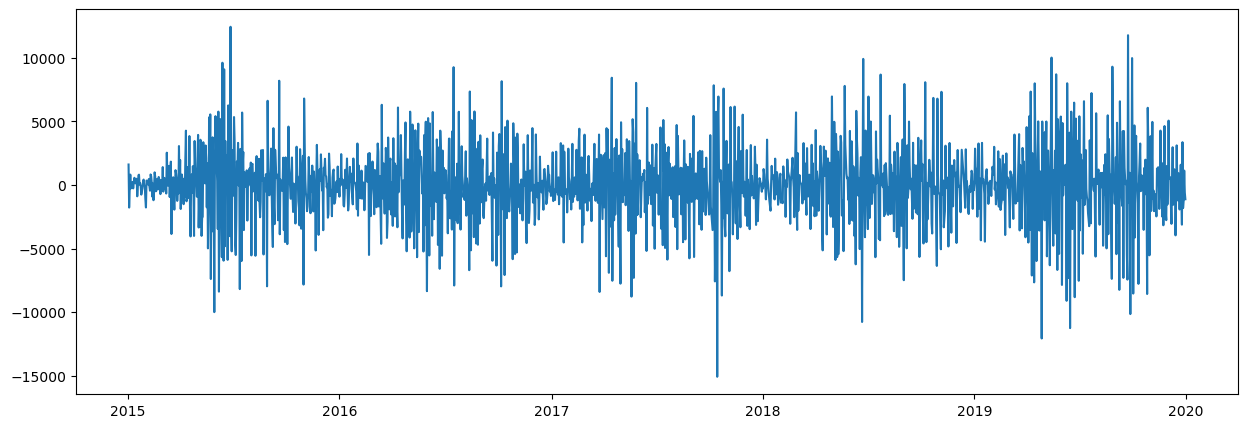

In [29]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff['trip_id'])

In [30]:
# Perform Dickey-Fuller test
result = adfuller(data_diff['trip_id'])

# Extracting test statistics and p-value
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

# Print the results
print('Dickey-Fuller Test Statistic:', adf_statistic)
print('p-value:', p_value)
print('Critical Values:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')

Dickey-Fuller Test Statistic: -17.988649852218035
p-value: 2.7591467812382065e-30
Critical Values:
   1%: -3.4341159453366448
   5%: -2.863203454843483
   10%: -2.5676555752134256


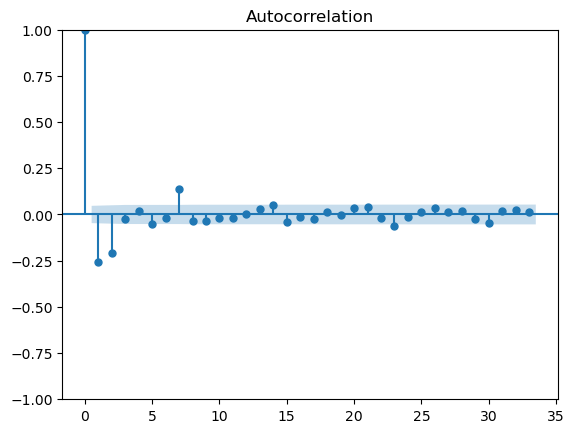

In [31]:
plot_acf(data_diff['trip_id'])
plt.show()

#### The test statistic is much lower than all the critical values, and the p-value is extremely low. This means we can reject the null hypothesis of a unit root (non-stationarity). Therefore, data appears to be stationary.